# <font color='blue'>Data Science Academy - Projeto 7</font>

# <font color='blue'>Medicina Personalizada - Redefinindo o Tratamento de Câncer</font>

### Modelo de Classificação Supervisionada

****** Stefani Henrique Ramalho ******

In [88]:
### Importando os modulos
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTENC #balancear as classes
from sklearn.model_selection import train_test_split

### Modulos para trabalhar com Text Mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


### Modulos para criacao e avaliacao dos modelos
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.decomposition import TruncatedSVD

### Modulos de Deep Learning
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

### Modulos de visualização gráfica
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

### suprimindo warnings
import warnings
warnings.filterwarnings('ignore')

### Leitura e tratamento dos dados

In [89]:
# Lendo o conjunto de dados de treino
treino = pd.read_csv('dados/training_variants.zip', compression='zip', sep=',', quotechar='"')

# Lendo os dados para teste
teste1 = pd.read_csv('dados/test_variants.zip', compression='zip', sep=',', quotechar='"') # stage 1
teste2 = pd.read_csv('dados/stage2_test_variants.csv') #stage 2

In [90]:
# Visualizando as primeiras e ultimas linhas dos dados de treino
treino.head().append(treino.tail())

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
3316,3316,RUNX1,D171N,4
3317,3317,RUNX1,A122*,1
3318,3318,RUNX1,Fusions,1
3319,3319,RUNX1,R80C,4
3320,3320,RUNX1,K83E,4


In [91]:
# Shape dos dados
print(treino.shape) # treino
print(teste1.shape) # teste stage 1
print(teste2.shape) # teste stage 2

(3321, 4)
(5668, 3)
(986, 3)


In [92]:
# Lendo os textos dos dados de treino
treino_tx = pd.read_csv("dados/training_text.zip", compression='zip', encoding="utf8",
                       quotechar='"', sep='\|\|', skiprows=1, names=["ID","Text"])

# Lendo as duas bases de teste
teste_tx1 = pd.read_csv("dados/test_text.zip", compression='zip', sep='\|\|', encoding="utf8",
                          quotechar='"', skiprows=1, names=["ID","Text"]) #stage 1

teste_tx2 = pd.read_csv("dados/stage2_test_text.csv", encoding="utf8", 
                        quotechar='"', sep='\|\|', skiprows=1, names=["ID","Text"]) # stage 2

# Visualizando as primeiras e ultimas linhas dos textos referente aos dados de treinamento
treino_tx.head().append(treino_tx.tail())

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,The most frequent mutations associated with le...


In [93]:
# Concatenando os dados de treino com os textos
df_treino = pd.concat([treino, treino_tx.drop('ID', axis = 1)], axis = 1).reset_index(drop=True)

# Concatenando os dados de teste com os textos
df_teste1 = pd.concat([teste1, teste_tx1.drop('ID', axis = 1)], axis = 1).reset_index(drop=True) # stage1
df_teste2 = pd.concat([teste2, teste_tx2.drop('ID', axis = 1)], axis = 1).reset_index(drop=True) # stage2

# Visualizando o dataset de treino
df_treino.head().append(df_treino.tail())

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,RUNX1,K83E,4,The most frequent mutations associated with le...


In [94]:
# Visualizando os dados de teste
df_teste1.head().append(df_teste1.tail()) # stage1

,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...
5663,5663,SLC46A1,R113S,The realization in the late 1970s that RAS har...
5664,5664,FOXC1,L130F,Hemizygous deletions are common molecular abno...
5665,5665,GSS,R267W,All most R267W of has with to SMARTpool invest...
5666,5666,CTSK,G79E,Abstract Blood samples from 125 unrelated fami...
5667,5667,DFNB59,T54I,"Loss of DNA mismatch repair (MMR) in humans, m..."


In [95]:
# Visualizando os dados de teste
df_teste2.head().append(df_teste2.tail()) # stage2

,ID,Gene,Variation,Text
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...
981,982,TP63,S580P,IκB kinase β (IKKβ) is involved in tumor devel...
982,983,SCN4A,R672G,he identification of subtype-specific transloc...
983,984,BRAF,N581H,Cardio-facio-cutaneous (CFC) syndrome (MIM 115...
984,985,TSHR,S281N,Screening for tumor suppressor genes in breast...
985,986,ASS1,S180N,"Histiocytic neoplasms are clonal, hematopoieti..."


In [96]:
# Buscando por valores missing
print(df_treino.isnull().sum()) # dados de treino
print(df_teste1.isnull().sum()) # dados de teste stage 1
print(df_teste2.isnull().sum()) # dados de teste stage 2

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64
ID           0
Gene         0
Variation    0
Text         1
dtype: int64
ID           0
Gene         0
Variation    0
Text         0
dtype: int64


In [97]:
# Foram encontrados valores missing que serão subistituidos pela moda

# Atribuindo a moda a um objeto para
moda_treino = df_treino.Text.mode()[0]
moda_teste = df_teste1.Text.mode()[0]

df_treino.fillna(moda_treino, inplace = True)
df_teste1.fillna(moda_teste, inplace = True)

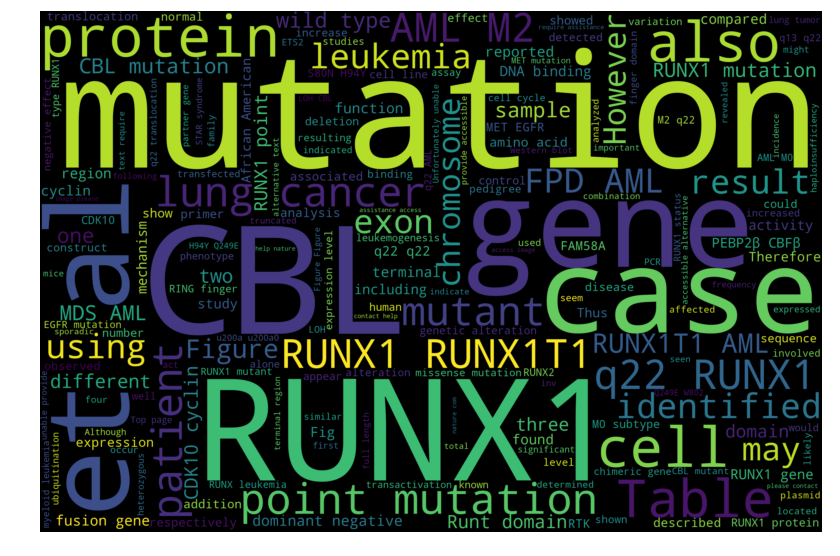

In [98]:
# Gerando uma nuvem de palavras para avaliar quais são os termos mais presentes nos dados de treinamento

# Definindo as stopwords
stopwds = stopwords.words('english')

# Objeto com os textos do dataset
text = df_treino.Text.values

# Gerando o grafico
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stopwds).generate(str(text))

# Plotando a nuvem de palavras
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18) 

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [99]:
# Tabela de contingênia por Classes
# As classes estão desbalanceadas
df_treino.groupby('Class').size()

Class
1    568
2    452
3     89
4    686
5    242
6    275
7    953
8     19
9     37
dtype: int64

In [100]:
# Função para balancear as classes dos dados de treinamento
def balancear(df):
    
    # dividindo os dados em atributos e variavel alvo
    x = df.drop("Class", axis = 1).values
    y = df.Class.values

    # criando uma lista com os nomes dos atributos
    atributos = df.columns.drop("Class")

    # Balanceando os dados
    sm = SMOTENC(categorical_features = [1,2,3], random_state = 37)
    x_res, y_res = sm.fit_resample(x, y)

    # criando novo dataset com os dados balanceados
    treino_smote = pd.DataFrame(x_res, columns = atributos)
    treino_smote['Class'] = y_res
    
    return treino_smote

# Chamando a função para balancear os dados
treino_smote = balancear(df_treino)

In [101]:
# Nova tabela de contingencia com as classes balanceadas
treino_smote.groupby('Class').size()

Class
1    953
2    953
3    953
4    953
5    953
6    953
7    953
8    953
9    953
dtype: int64

In [102]:
# Salvando dados de treino, teste e validacao
treino_smote.to_csv("dados/treino_df.csv", index = False) # treino

df_teste1.to_csv("dados/teste_df1.csv", index = False) # stage1

df_teste2.to_csv("dados/teste_df2.csv", index = False) # stage2 

### Criando o modelo baseadado nas informações contida nos textos

In [103]:
# Carregando os dados para treinar o modelo
treino_df = pd.read_csv("dados/treino_df.csv")

In [104]:
# Funcao para criar um saco de palavras
def bag_words(df):
    
    count_vectorizer = CountVectorizer(stop_words='english', analyzer="word",
                                   tokenizer= word_tokenize, preprocessor=None, max_features= None, lowercase=False)

    bag_of_words = count_vectorizer.fit_transform(df.Text)
    
    return bag_of_words

In [105]:
# Criando o saco de palavras
bag_of_words = bag_words(treino_df)

# Visualizando o shape
bag_of_words.shape

(8577, 305648)

In [106]:
# Criando uma fucao para criar um novo dataset com n dimencoes utilizando o metodo SVD
def reducao(classe, bag_of_words, n = 25):
    
    svd = TruncatedSVD(n_components=n, n_iter=25, random_state=124)
    truncated_bag_of_words = svd.fit_transform(bag_of_words)
    
    # Criando o novo dataset
    df_geral_svd = pd.DataFrame(truncated_bag_of_words)
    df_geral_svd['Class'] = classe
    
    return(df_geral_svd)

In [107]:
# Criando o dataset com 25 dimensoes
df_geral_svd = reducao(treino_df.Class, bag_of_words)

In [108]:
# Shape dos dados
df_geral_svd.shape

(8577, 26)

In [109]:
# Visualizando o novo dataset
df_geral_svd.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Class
0,589.515379,-21.847088,-34.693032,20.977078,-12.937948,-33.262121,57.435304,5.205629,-19.772562,-10.436986,...,-1.866073,-0.297385,43.638675,12.312268,10.668778,14.627675,29.764081,-19.442004,18.897803,1
1,459.637878,30.697884,55.730805,-8.731227,47.267145,28.231796,20.237256,22.108467,-14.028074,-32.209278,...,8.139728,-18.905269,-18.588379,-15.515033,10.537812,9.759045,1.624131,-7.289438,5.273605,2
2,459.637878,30.697884,55.730805,-8.731227,47.267145,28.231796,20.237256,22.108467,-14.028074,-32.209278,...,8.139728,-18.905269,-18.588379,-15.515033,10.537812,9.759045,1.624131,-7.289438,5.273605,2
3,389.307614,-36.109903,19.358386,31.220727,-8.058731,7.270272,1.959758,-13.868664,13.842757,12.579753,...,-2.209855,-5.990395,0.922338,-1.067689,-0.354656,2.949269,-23.307176,-1.548231,19.067212,3
4,499.960310,-73.103980,-4.819614,79.130204,-5.765568,14.698654,37.460971,-78.946286,29.982379,-1.045217,...,12.504371,-3.143535,-27.805782,-3.409222,18.108855,29.083654,-3.343472,-0.067146,23.885794,4


### Criando um modelo com ExtraTreesClassifier

In [110]:
# Definindo valores para X e y
X = df_geral_svd.drop('Class', axis = 1)
y = df_geral_svd.Class

# Dividindo os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=142)

# Criando modelo com ExtraTreesClassifier
modelo1 = ExtraTreesClassifier(n_estimators = 500, max_depth = 12,
                           min_samples_split = 2, random_state = 124).fit(x_train, y_train)

In [111]:
# Prevendo os dados de teste
pred = modelo1.predict(x_test)

# Criando uma confusion matrix para avaliar os resultados
confusion_matrix(y_test, pred)

array([[169,  18,   1,  31,  24,  18,  38,   0,   0],
       [  7, 245,   0,   1,   2,   2,  57,   0,   0],
       [  1,   0, 252,  21,   2,   0,   7,   0,   0],
       [ 27,  18,   7, 200,  15,   4,  28,   0,   0],
       [  9,  14,   3,   3, 227,   9,  21,   0,   0],
       [  7,  12,   0,   5,   4, 248,  12,   0,   0],
       [  8,  35,   7,   3,   5,   0, 208,   0,   0],
       [  0,   0,   0,   0,   0,   0,   3, 278,   1],
       [  0,   0,   0,   0,   0,   0,   1,   0, 256]], dtype=int64)

In [112]:
# acuracia do modelo com base nos dados de teste
accuracy_score(y_test, pred)

0.8092463092463092

### Criando o modelo com Deep Learning

In [113]:
# Criando uma funcao para tokeninzar os textos
def tokenizar(texto, max = 2000):
    
    tokenizer = Tokenizer(num_words = max)
    tokenizer.fit_on_texts(treino_df.Text)

    X_token = tokenizer.texts_to_sequences(texto)
    X_token = pad_sequences(X_token, maxlen=max)
    
    return X_token

In [114]:
# Criando uma matriz com os textos tokenizados
X_token = tokenizar(treino_df.Text)

In [115]:
# Shape dos dados para novo treinamento
X_token.shape

(8577, 2000)

In [116]:
# Definindo os parametros para o modelo
embed_dim = 128
lstm_out = 196
num_words = 2000 # maximo de palavras

# Criando o modelo com 3 camadas
ckpt_callback = ModelCheckpoint('keras_model', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

modelo2 = Sequential()
modelo2.add(Embedding(num_words, embed_dim, input_length = X_token.shape[1]))
modelo2.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
modelo2.add(Dense(9,activation='softmax'))
modelo2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])

In [117]:
# Visualizando o modelo
modelo2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________


In [118]:
# Criando uma matriz com as classes (hot encoding)
y_token = pd.get_dummies(treino_df.Class).values

In [119]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_token, y_token, test_size = 0.3, random_state = 42, stratify=y_token)

In [120]:
# Treinando o modelo com epochs = 10
batch_size = 32
modelo2.fit(X_train, y_train, epochs=10, batch_size = batch_size, validation_split = 0.3, callbacks=[ckpt_callback])

Train on 4202 samples, validate on 1801 samples
Epoch 1/10
4202/4202 [==============================] - 797s 190ms/step - loss: 1.5270 - categorical_crossentropy: 1.5270 - val_loss: 1.0535 - val_categorical_crossentropy: 1.0535

Epoch 00001: val_loss improved from inf to 1.05350, saving model to keras_model
Epoch 2/10
4202/4202 [==============================] - 768s 183ms/step - loss: 0.9033 - categorical_crossentropy: 0.9033 - val_loss: 0.8579 - val_categorical_crossentropy: 0.8579

Epoch 00002: val_loss improved from 1.05350 to 0.85789, saving model to keras_model
Epoch 3/10
4202/4202 [==============================] - 760s 181ms/step - loss: 0.6825 - categorical_crossentropy: 0.6825 - val_loss: 0.7828 - val_categorical_crossentropy: 0.7828

Epoch 00003: val_loss improved from 0.85789 to 0.78278, saving model to keras_model
Epoch 4/10
4202/4202 [==============================] - 758s 180ms/step - loss: 0.5642 - categorical_crossentropy: 0.5642 - val_loss: 0.7424 - val_categorical_cr

In [121]:
# Prevendo os dados de teste
prob = modelo2.predict(X_test)
pred_indices = np.argmax(prob, axis=1)

classes = np.array(range(1, 10))
pred = classes[pred_indices]

In [122]:
# acuracia do modelo com base nos dados de teste
accuracy_score(classes[np.argmax(y_test, axis=1)], pred)

0.7843822843822844

In [123]:
# Criando uma confusion matrix para avaliar os resultados
confusion_matrix(classes[np.argmax(y_test, axis=1)], pred)

array([[159,  21,   2,  43,  38,  14,   9,   0,   0],
       [ 11, 203,   1,  17,  12,   7,  34,   1,   0],
       [  1,   0, 254,  15,   4,   8,   4,   0,   0],
       [ 37,   3,   7, 206,   7,  17,   9,   0,   0],
       [  6,   0,   1,  13, 229,  28,   9,   0,   0],
       [  7,   5,   0,   5,   8, 256,   5,   0,   0],
       [ 27,  51,   4,  11,  26,  13, 149,   5,   0],
       [  1,   0,   0,   1,   0,   0,   0, 281,   3],
       [  2,   0,   0,   1,   0,   0,   1,   0, 282]], dtype=int64)

### Prevendo os dados para submissão

In [124]:
# Carregando os dados para treinar o modelo
teste_df1 = pd.read_csv("dados/teste_df1.csv") # stage 1
teste_df2 = pd.read_csv("dados/teste_df2.csv") # stage 2

In [125]:
# Criando uma matriz com os textos tokenizados
X_teste1 = tokenizar(teste_df1.Text) # stage 1
X_teste2 = tokenizar(teste_df1.Text) # stage 2

In [126]:
# Prevendo os dados do stage 1
prob_1 = modelo2.predict(X_teste1)
pred_indices_1 = np.argmax(prob_1, axis=1)

classes = np.array(range(1, 10))
pred_1 = classes[pred_indices_1]

# Prevendo os dados do stage 2
prob_2 = modelo2.predict(X_teste2)
pred_indices_2 = np.argmax(prob_2, axis=1)

classes = np.array(range(1, 10))
pred_2 = classes[pred_indices_2]